In [84]:
# Import necessary packages
import torch
import numpy as np
from dataset import Chexpert_dataset
import os
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

In [85]:
# Load results
df = pd.read_csv('results_Atelectasis.csv',index_col=[0])
print('Number of samples = ', len(df))

Number of samples =  38205


In [71]:
# Create new column to stratify data and calculate base rates
group = []
for i in tqdm(range(df.shape[0])):
    # w
    if np.sum(df[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(df[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(df[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(df[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
df['group'] = group

# Calculate base rates
total = df.shape[0]
r = np.sum(df['group'] == 4)/total
s = np.sum(df['group'] == 3)/total
v = np.sum(df['group'] == 2)/total
w= np.sum(df['group'] == 1)/total
print('min rate = ', min(r,s,w,v))

100%|██████████| 38205/38205 [01:55<00:00, 330.94it/s]

min rate =  0.06284517733280984


In [87]:
# Change column names 
df = df.rename(columns={'Paths': 'Path','a': 'Sex','y': 'Cardiomegaly'})

In [88]:
# Enable GPU use
os.environ['CUDE_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

# Get model
sex_model = densenet121(weights = DenseNet121_Weights.DEFAULT)

# Fix last layer of densenet to reflect number of classes
input_num = sex_model.classifier.in_features
sex_model.classifier = nn.Linear(input_num,1)

# Load pre-trained model
sex_model.load_state_dict(
    torch.load(os.path.join('pretrained_sex_model', "model.pt"), map_location=device)
)
sex_model = sex_model.to(device)

In [89]:
# Set in evaluation mode
sex_model.eval()

# Root dir (needs to be changed depending on if I am using remote or gaon)
root_dir_gaon = '/export/gaon1/data/bbharti1'

# Additional specifications
columns = ['Sex']
transform = transforms.Resize((320,320))
all_data = Chexpert_dataset(df,root_dir_gaon,columns,transform = transform)

In [90]:
# Evaluate model
# indices = np.arange(0,7000)
# sub_data = Subset(all_data,indices)
dataloader = DataLoader(all_data, batch_size=16, shuffle=False)

In [91]:
a_probs_list = []
torch.set_grad_enabled(False)
for i, data in enumerate(tqdm(dataloader)):
    image, label, image_paths = data
    image = image.to(device)
    label = label.to(device)

    output = sex_model(image)
    output = torch.sigmoid(output)
    a_probs_list.append(output)
a_probs = torch.cat(a_probs_list).cpu().ravel()

100%|██████████| 2388/2388 [02:28<00:00, 16.05it/s]


In [93]:
a_hat = (a_probs >=0.5)
a_hat = a_hat.cpu().numpy().astype('float')
U = np.sum(a_hat != df.Sex.values)/len(a_hat)
print('a_hat error = ', U)

a_hat error =  0.005130218557780395


In [105]:
# Load results
df = pd.read_csv('results_Atelectasis.csv',index_col=[0])
df['y_hat'] = df['y_probs']
# Change column names 
df = df.rename(columns={'y_probs': 'y_prob'})
y = df.y.values
y_ = df.y_prob.values
a = df.a.values
# add a_hat
df['a_hat'] = a_hat

In [110]:
B = 100
bias_tpr = []
post_bias_tpr = []
upper_bound = []
lower_bound = []
post_upper_bound = []
post_lower_bound = []
for i in tqdm(range(B)):
    # Bootstrapping
    df_sample = df.sample(n=1000,replace=True)
    alpha,beta,tau,phi = calculate_bias_metrics(df_sample)
    bias_tpr.append(alpha-beta)
    df_a_hat = df_sample.copy(deep=True)
    df_a_hat['a'] = df_sample['a']
    alpha_hat,beta_hat,tau_hat,phi_hat = calculate_bias_metrics(df_a_hat)
    ub, lb = calc_gen_bounds(alpha_hat,beta_hat,U,r,s)
    upper_bound.append(ub)
    lower_bound.append(lb)

    # Post process
    _, fair_model = eo_postprocess(df_a_hat)
    y_fair = fair_model.predict(df_a_hat.y_prob.values,df_a_hat.a.values)
    df_fair = df_a_hat.copy(deep=True)
    df_fair['y_hat'] = y_fair
    # Calculate post bias_tpr
    alpha,beta,tau,phi = calculate_bias_metrics(df_fair)
    post_bias_tpr.append(alpha-beta)
    ub, lb = calc_gen_bounds(alpha,beta,U,r,s)
    post_upper_bound.append(ub)
    post_lower_bound.append(lb)

100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


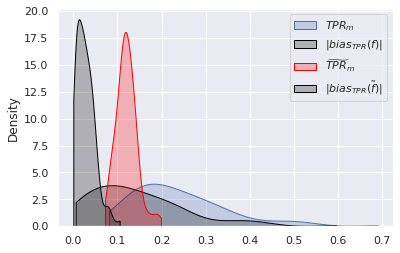

In [108]:
max_bound_pre = np.maximum(np.abs(upper_bound),np.abs(lower_bound))
max_bound_post = np.maximum(np.abs(post_upper_bound),np.abs(post_lower_bound))
sns.kdeplot(max_bound_pre,shade=True,cut=0,label = '$TPR_{m}$')
sns.kdeplot(np.abs(bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(f)|$', color = 'black')
sns.kdeplot(max_bound_post,shade=True,cut=0,label = r'$\widetilde{TPR}_{m}$', color = 'red')
sns.kdeplot(np.abs(post_bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(\tilde{f})|$',color='black')
plt.legend()

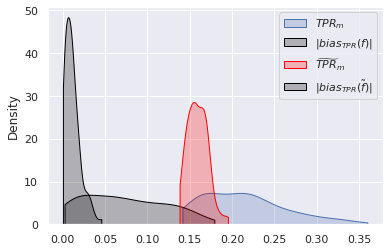

In [39]:
max_bound_pre = np.maximum(np.abs(upper_bound),np.abs(lower_bound))
max_bound_post = np.maximum(np.abs(post_upper_bound),np.abs(post_lower_bound))
sns.kdeplot(max_bound_pre,shade=True,cut=0,label = '$TPR_{m}$')
sns.kdeplot(np.abs(bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(f)|$', color = 'black')
sns.kdeplot(max_bound_post,shade=True,cut=0,label = r'$\widetilde{TPR}_{m}$', color = 'red')
sns.kdeplot(np.abs(post_bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(\tilde{f})|$',color='black')
plt.legend()